In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import h5py

In [4]:
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

# sklearn functions
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold, GroupShuffleSplit

# load functions from nitorch
sys.path.insert(0,"/analysis/ritter/AD/Budding_Spectral_Analysis/code/nitorch/")
from nitorch.data import load_nifti
from nitorch.transforms import  ToTensor, SagittalTranslate, SagittalFlip, \
                                AxialTranslate, normalization_factors, Normalize, \
                                IntensityRescale
from nitorch.callbacks import EarlyStopping, ModelCheckpoint
from nitorch.trainer import Trainer
from nitorch.initialization import weights_init
from nitorch.metrics import balanced_accuracy, sensitivity, specificity
from nitorch.utils import count_parameters
from nitorch.inference import predict

In [5]:
torch.__version__

'1.0.0'

In [6]:
gpu = 0
b = 4
num_classes = 2

dtype = np.float64

In [7]:
# Inference on all mci data
holdout_h5 = h5py.File("/analysis/ritter/projects/AD/Budding_Spectral_Analysis/data/ADNI_mci_all.h5", 'r')

In [9]:
X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']

In [10]:
mean_std_normalization = False
min_max_normalization = True

In [11]:
X_holdout = np.array(X_holdout)
y_holdout = np.array(y_holdout)

if mean_std_normalization:
    mean = np.mean(X_train)
    std = np.std(X_train)
    X_holdout = (X_holdout - mean) / std
    
if min_max_normalization:

    for i in range(len(X_holdout)):
        X_holdout[i] -= np.min(X_holdout[i])
        X_holdout[i] /= np.max(X_holdout[i])

In [12]:
class ADNIDataset(Dataset):
    def __init__(self, X, y, transform=None, target_transform=None, mask=None, z_factor=None, dtype=np.float32, num_classes=2):
        self.X = np.copy(X)
        self.y = np.copy(y)
        self.X = X
        self.y = y
        self.transform = transform
        self.target_transform = target_transform
        self.mask = mask
        self.z_factor = z_factor
        self.dtype = dtype
        self.num_classes = num_classes
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        label_tensor = np.zeros(shape=(self.num_classes,))
        label = self.y[idx] >= 0.5
        label = torch.LongTensor([label])
        
        if self.transform:
            image = self.transform(image)
            
        sample = {"image" : image,
                 "label" : label}
        return sample

In [13]:
augmentations = [SagittalFlip(), SagittalTranslate(dist=(-2, 3))]

In [14]:
adni_data_test = ADNIDataset(X_holdout, y_holdout, transform=transforms.Compose([ToTensor()]), dtype=dtype)

In [15]:
sample = adni_data_test[50]
img = sample["image"]
print(img.shape)

torch.Size([1, 182, 218, 182])


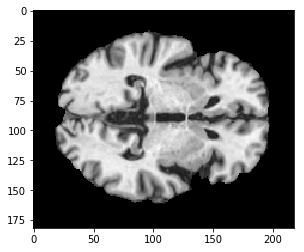

In [16]:
plt.imshow(img[0][:,:,70], cmap='gray')

# Define the classifier

In [17]:
class ClassificationModel3D(nn.Module):
    """The model we use in the paper."""

    def __init__(self, dropout=0.4, dropout2=0.4):
        nn.Module.__init__(self)
        self.Conv_1 = nn.Conv3d(1, 8, 3, bias = False)
        self.Conv_1_bn = nn.BatchNorm3d(8)
        self.Conv_1_mp = nn.MaxPool3d(2)
        self.Conv_2 = nn.Conv3d(8, 16, 3, bias = False)
        self.Conv_2_bn = nn.BatchNorm3d(16)
        self.Conv_2_mp = nn.MaxPool3d(3)
        self.Conv_3 = nn.Conv3d(16, 32, 3, bias = False)
        self.Conv_3_bn = nn.BatchNorm3d(32)
        self.Conv_3_mp = nn.MaxPool3d(2)
        self.Conv_4 = nn.Conv3d(32, 64, 3, bias = False)
        self.Conv_4_bn = nn.BatchNorm3d(64)
        self.Conv_4_mp = nn.MaxPool3d(3)
        self.dense_1 = nn.Linear(2304, 128)
        self.dense_2 = nn.Linear(128, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout2)

    def forward(self, x):
        x = self.relu(self.Conv_1_bn(self.Conv_1(x)))
        x = self.Conv_1_mp(x)
        x = self.relu(self.Conv_2_bn(self.Conv_2(x)))
        x = self.Conv_2_mp(x)
        x = self.relu(self.Conv_3_bn(self.Conv_3(x)))
        x = self.Conv_3_mp(x)
        x = self.relu(self.Conv_4_bn(self.Conv_4(x)))
        x = self.Conv_4_mp(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.relu(self.dense_1(x))
        x = self.dropout2(x)
        x = self.dense_2(x)
        return x

In [18]:
net = ClassificationModel3D().cuda(gpu)

In [19]:
print("Trainable model parameters: {}".format(count_parameters(net)))

Trainable model parameters: 368330


# Start inference

In [20]:
model_path = "/analysis/ritter/projects/AD/Budding_Spectral_Analysis/models/model_final"

In [21]:
# load models
models = []
for i in range(4):
    model_dir = os.path.join(model_path, "repeat_0_cv_fold_{}_BEST_ITERATION.h5".format(i))
#     model_dir = os.path.join(output_dir, "repeat_0_cv_fold_{}_BEST_ITERATION.h5".format(i))
    net = ClassificationModel3D()
    net.load_state_dict(torch.load(model_dir))
    models.append(net)

In [22]:
test_loader = DataLoader(
            adni_data_test, batch_size=1, num_workers=1, shuffle=False
)

In [23]:
metrics = []
lr = 1e-5
wd = 1e-3
criterion = nn.BCEWithLogitsLoss().cuda(gpu)
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    
for fold, model in enumerate(models):
    print("Fold {}".format(fold))

    all_preds = []
    all_labels = []
    
    net = model.cuda(gpu)
    net.eval()
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]
            
            img = img.to(torch.device("cuda:" + str(gpu)))
            output = net.forward(img)
            pred = predict(output, label, all_preds, all_labels, 'binary', criterion, class_threshold = 0.61)
    
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    print(balanced_acc)
    '''trainer = Trainer(
                net,
                criterion,
                optimizer,
                scheduler=None,
                metrics=metrics,
                callbacks=None,
                device=gpu,
                prediction_type="binary"
            )
    computed_metrics = trainer.evaluate_model(test_loader, metrics=[balanced_accuracy])'''
    net.train()
    metrics.append(balanced_acc)
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics)
print(metrics_df)
print("Balanced accuracy mean {:.2f} %".format(np.mean(metrics_df[0])*100))


Fold 0
0.675751244138129
Fold 1
0.6614357202200392
Fold 2
0.6895202581293352
Fold 3
0.668090444632748
######## Final results ########
          0
0  0.675751
1  0.661436
2  0.689520
3  0.668090
Balanced accuracy mean 67.37 %


In [24]:
quit()

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.
